In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('../..')

from utils.workflow import WorkflowModel
import utils.plotting as plotting
from utils.eval import eval_predictions

2026-02-05 12:26:29.736693: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-05 12:26:29.776675: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-05 12:26:30.828544: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


E0000 00:00:1770305191.956434  268278 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1770305191.963003  268278 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
df = pd.read_csv("../../data/influenza_england_1978_school.csv")

In [3]:
I_data = df["in_bed"].to_numpy()

In [4]:
I_data

array([  3,   8,  26,  76, 225, 298, 258, 233, 189, 128,  68,  29,  14,
         4])

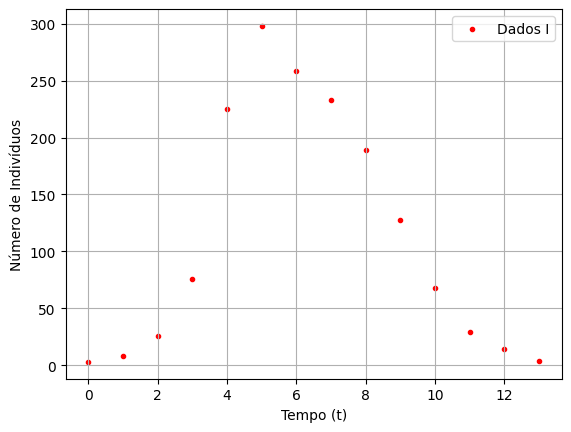

In [5]:
t_0, t_f = 0, len(I_data) - 1
data_t = np.linspace(t_0, t_f, len(I_data))
plotting.plot_incidence_data(data_t, I_data, "dados-english-boardschool")

In [6]:
N = 763
gamma = 0.457
# gamma = 0.5
data_t = np.linspace(t_0, t_f, len(I_data))

In [7]:
model = WorkflowModel(t_0, t_f, I_data, data_t, N, gamma, 
    scaling="norm",
    w_physics=100,
    beta_estimation_window=5,
    estimate_beta=True
)
model.S0, model.I0, model.beta0

Compiling model...
'compile' took 0.006899 s



(np.float64(0.9960681520314548),
 np.float64(0.003931847968545216),
 np.float64(1.5456268025679114))

In [8]:
model.train()

(<deepxde.model.LossHistory at 0x7fb024611290>,
 <deepxde.model.TrainState at 0x7fb0247e26d0>)

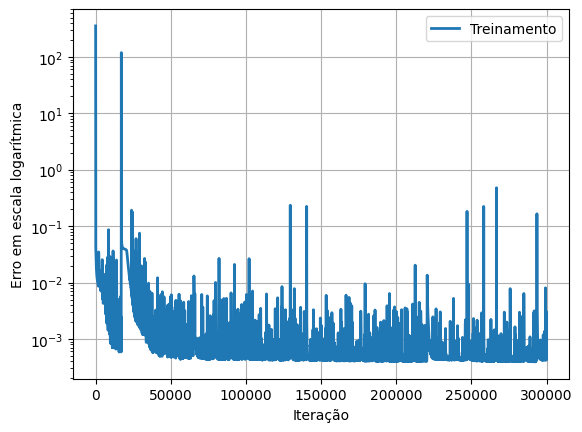

In [9]:
plotting.plot_losshistory(model.losshistory, "loss-english-boardschool")

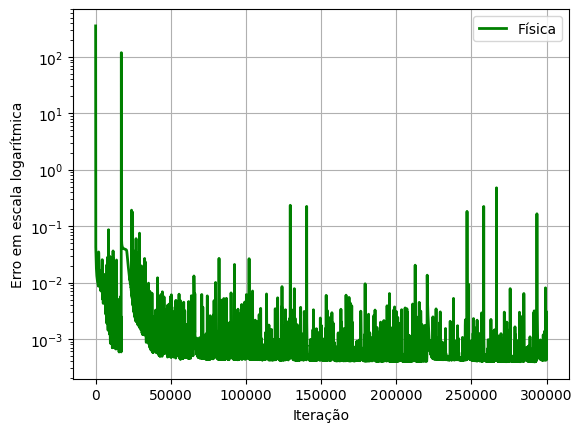

In [10]:
plotting.plot_phys_losshistory(model.losshistory, model.n_physics, "loss-phys-english-boarding-school")

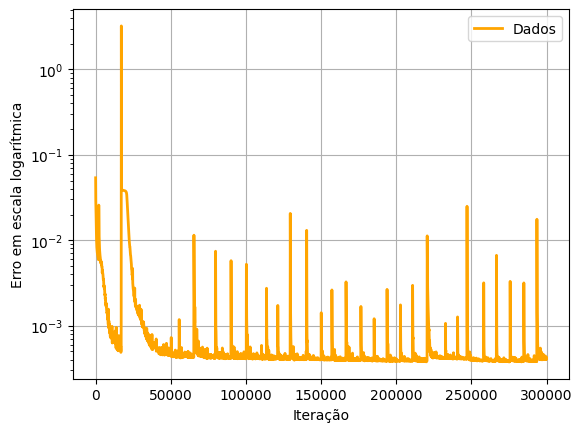

In [11]:
plotting.plot_data_losshistory(model.losshistory, "loss-data-english-boarding-school")

In [12]:
test_t = np.linspace(t_0, t_f, 50)
pred = model.predict(test_t)

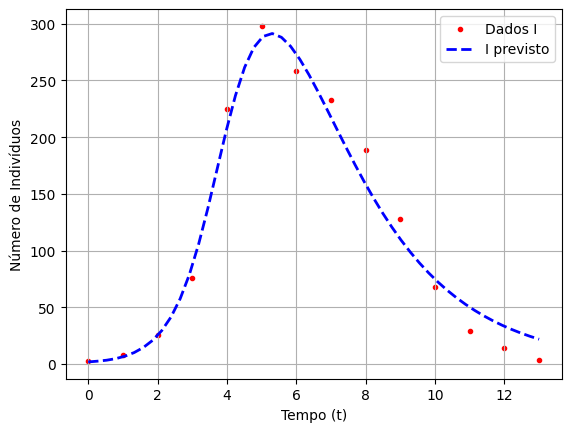

In [ ]:
plotting.plot_incidence_results(I_data, data_t, pred[:,1], test_t, "results-english-boarding-school")

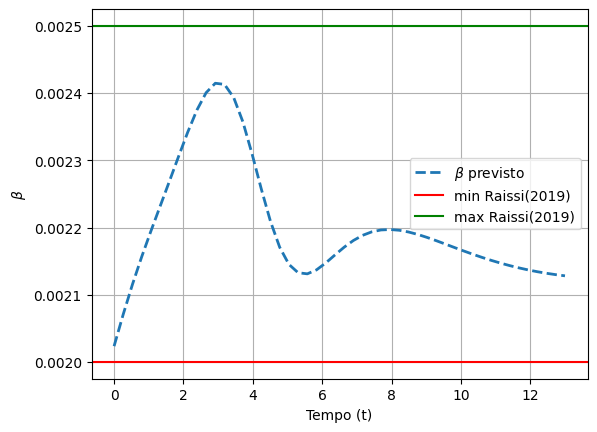

In [14]:
min_raissi = 0.002
max_raissi = 0.0025
plotting.plot_beta_prediction(model.scale(pred[:,2]), test_t,
    hlines=[
        (min_raissi, "min Raissi(2019)", "red"), 
        (max_raissi, "max Raissi(2019)", "green")
    ],
    figname="beta-english-boarding-school")

In [15]:
if model.data_weight_hist:
    plotting.plot_wdata(model.data_weight_hist, "wdados-english-boarding-school")

In [16]:
pred_eval = model.predict(data_t)
eval_predictions(np.array([I_data]) , np.array([pred_eval[:,1]]), compartiments=["I"])

,compartiment,RMSE,L2,L-infinity
0,I,1.072276,0.357425,1.072276


In [17]:
model.formated_total_training_time

'00:04:46'